# Solving Second Order Differential Equations with Neural Networks

*Based on the paper [Artificial Neural Networks for Solving Ordinary and Partial Differential Equations by I. E. Lagaris, A. Likas and D. I. Fotiadis(1997)](https://arxiv.org/abs/physics/9705023)*

**Problem:** Find solution of 
$$
    u''(x) = \underbrace{- \frac{1}{5} u'(x) - u(x)- \frac{1}{5} e^{-(\frac{x}{5})} \cos(x)}_{=f(x, u(x), u'(x))}
$$

with $u(0) = 0, \; u'(0) = 1$ on the interval $[0,2]$. 

## Notation

$u_N$ denotes the **trial solution** of a neural network, that we will train in the following.

$u_a$ denotes the **analytic solution** or the *target function* of the ODE above. This is what our neural network should learn. The exact analytic solution of the ODE above reads 

$$
    \Psi_a(x) = \exp(-\frac{1}{5}x)\sin(x) \tag{1}.
$$

## Key Idea

Write 

$$u_N(x) = x + x^2 N_p(x),$$

where $N_p(x)$ is the neural network with training parameter $p$. We can easily see that

$$
    u_N(0) = 0 + 0 \cdot N(0, p) = 0 \ 
$$
Observe that 
$$u_N'(x) = 1 + 2x  N_p(x) + x^2 N_p'(x),$$
and therefore 
$$ u_N'(0) = 1  $$
Thus, this ansatz satisfies the initial value condition. It just remains to adjust the parameter $p$ such that $u_N(x) = x + x^2 N_p(x)$ approximates the target function $u_a$ for any $x \in [0,2]$ very well.

## Architecture of the Neural Network

We use a neural network with **one hidden layer** containing **$H=10$ neurons** and the **sigmoid function** as the activation function. The neural network has one single input layer and a single linear output layer.

## Training the Neural Network

Discretize $[0,2]$ such that we have a grid of $10$ equidistant points $x_1,...,x_{10} \in [0,2]$. Define the **loss function** as

$$
    E = \sum_{i=1}^{10} \left(u_N''(x_i) - f(x_i, u_N(x_i), u_N'(x_i))\right)^2,
$$

where $f$ is the right hand side of the ODE.

In [0]:
%matplotlib inline
%tensorflow_version 1.x 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
# domain of the solution
DOMAIN = [0.0, 2.0]

# number of neurons in the hidden layer
WIDTH = 10 

# number of discretization points/ number of training points
NUM_TRAINING_POINTS = 10

# number of neurons in the input layer
INPUT_DIMENSION = 1

# grid of equidistant points in the DOMAIN
TRAINING_POINTS = xs = np.linspace(DOMAIN[0], DOMAIN[1], NUM_TRAINING_POINTS)

# see formula (1)
def target_func(x):
    return np.exp(-0.2*x)*np.sin(x)

Next, we construct our shallow neural network (one hidden layer).

In [0]:
initializer = tf.contrib.layers.xavier_initializer()

# Input layer
input = tf.placeholder(dtype=tf.float32, shape=(None, INPUT_DIMENSION, ), name="input")
batch_size = tf.shape(input)[0]
# Hidden layer
W = tf.Variable(initializer((WIDTH, INPUT_DIMENSION)), dtype=tf.float32, name="W") # Weights first hidden layer
b = tf.Variable(initializer((WIDTH,)), dtype=tf.float32, name="b") # Bias

z = tf.matmul(tf.broadcast_to(W, [batch_size,WIDTH,INPUT_DIMENSION] ), tf.reshape(input, shape=[-1, INPUT_DIMENSION, 1]))
z = z + tf.reshape(b, shape=(WIDTH, 1))
sigmoid_z = tf.nn.sigmoid(z)

# Single Output layer
v = tf.Variable(initializer((1,WIDTH)), dtype=tf.float32, name="v") # Weights output layer
output = tf.reshape(tf.matmul(tf.broadcast_to(v,[batch_size,1,WIDTH]), sigmoid_z), [-1,1,])


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Here we will construct the trial solution $u_N$ and the first and second derivative of $u_N$
$$u_N(x) = x + x^2 N_p(x) $$
$$ u_N'(x) = 1 + 2x  N_p(x) + x^2 N_p'(x) $$

$$ u_N''(x) = 2 N_p(x) + 4 N_p'(x) + x^2 N_p''(x) $$

In [0]:
# trial solution u_N(x) = x + x^2 N_p(x)
u = input + input* input * output 

# compute first derivative of u_N, u_N'(x) = 1 + 2x N_p(x) + x^2 N_p'(x)
vW = tf.multiply(tf.reshape(W, [WIDTH]), v)
sigmd1 = tf.multiply(tf.sigmoid(z), (1-tf.sigmoid(z)))
prod1 = tf.multiply(tf.reshape(vW, shape = (1, -1, 1)), sigmd1)
dN1 = tf.reduce_sum(prod1, axis = 1) # first derivative of N 
du1 = 1 + 2 * input * output + input*input * dN1

# compute second derivative of u_N, u_N''(x) = 2 N_p(x) + 4 x N_p'(x)+ x^2 N_p''(x)
W2 = W*W
vW2 = tf.multiply(tf.reshape(W2, [WIDTH]), v)
sigmd2 = tf.multiply(sigmd1 , (1- 2 *tf.sigmoid(z)))
prod2 = tf.multiply(tf.reshape(vW2, shape = (1, -1, 1)), sigmd2)
dN2 = tf.reduce_sum(prod2, axis = 1) # second derivative of N 
du2 = tf.add ( tf.add(2 * output, 4* input * dN1), input * input * dN2 )

# right hand side of ODE
f = -0.2 * du1 - u - tf.multiply(tf.multiply(0.2, tf.exp(-input * 0.2 )), tf.cos(input))

# loss function
loss = tf.reduce_sum(tf.square(du2 - f))

Training

Loss value: 0.000000015 Elapsed time53.38359


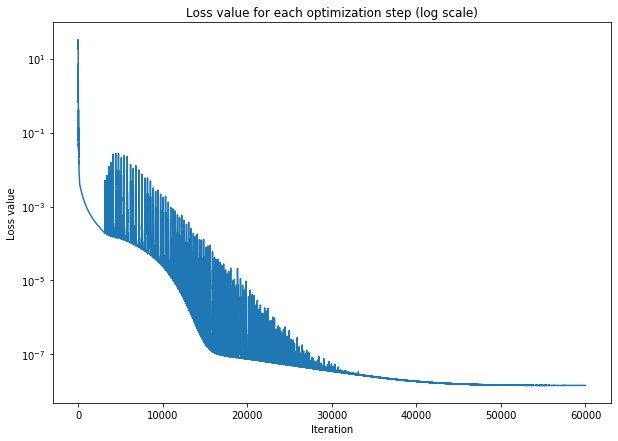

In [0]:
# Training parameters
#@markdown Number of training iterations
NUM_ITER = 60000 #@param {type:"integer"}
#@markdown Initial learning rate
INIT_L_RATE = 0.1 #@param {type:"number"}
#@markdown Final learning rate
FINAL_L_RATE = 1e-8 #@param {type:"number"}


global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    INIT_L_RATE,
    global_step,
    1,
    np.exp(np.log(FINAL_L_RATE/INIT_L_RATE) / NUM_ITER),
    staircase=True
)

# Optimizer
step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

session = tf.Session()
session.run(tf.global_variables_initializer())

ERROR_RATE = []
HISTORY = []

# Training
t0 = time.time()
for i in range(NUM_ITER):
    loss_val, _  = session.run(
        [loss, step],
        feed_dict={ input: np.reshape(np.array(xs), (-1,1)) }    
    )
    if (i % 2 == 0 and i<= 300):
        prediction = session.run([output], feed_dict={ input: np.reshape(np.linspace(0,2,100), (-1,1))})
        HISTORY.append(prediction)
    ERROR_RATE.append(loss_val)
t1 = time.time()

# Plotting
plt.figure(figsize = (10,7))
plt.title("Loss value for each optimization step (log scale)")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.plot(ERROR_RATE)

print("Loss value: {:0.9f}".format(ERROR_RATE[-1]), 'Elapsed time{:0.5f}'.format(float(t1-t0)))

Compare the trial solu of the neural network with the target function.

Text(0.5, 1.0, 'Approximation error of $u_N$ and $u_a$')

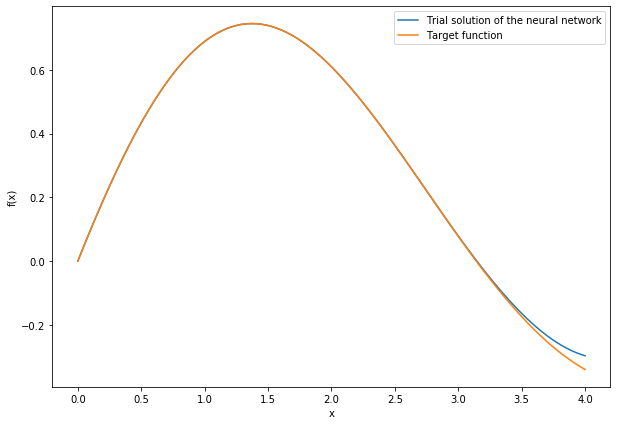

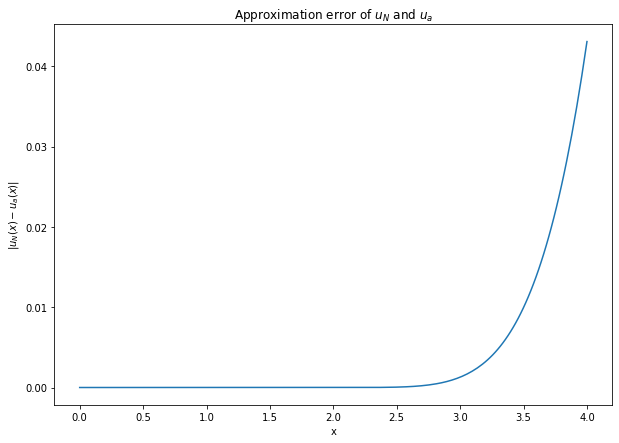

In [0]:
#@markdown Plots the functions from X_START to X_END
X_START = 0 #@param {type:"number"}
X_END =  4#@param {type:"number"}
RESOLUTION = 200
xaxis = np.linspace(X_START,X_END,RESOLUTION)

target = target_func(xaxis)
prediction = np.reshape(session.run(u,
                        feed_dict={input: np.reshape(xaxis,(-1,1))}
                        ), (-1,))

plt.figure(0, figsize=(10,7))
plt.plot(xaxis, prediction, label="Trial solution of the neural network")
plt.plot(xaxis, target, label="Target function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(loc=0)


plt.figure(1, figsize=(10,7))
plt.plot(xaxis, np.absolute(prediction-target))
plt.xlabel("x")
plt.ylabel("$|u_N(x) - u_a(x)|$")
plt.title("Approximation error of $u_N$ and $u_a$")

In [0]:
print("Length of History: {}".format(len(HISTORY)))
xaxis = np.linspace(0,2,100)
target = target_func(xaxis)

i = 0
for ys in HISTORY:
    fig = plt.figure(i,figsize=(10,7),dpi=300)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.axis([0.0,2.0,-0.4,1.0])
    plt.plot(xaxis, np.reshape(ys, (-1,))* xaxis, label="Iteration: {}. Error: {:0.2f}".format(2*i, ERROR_RATE[i*2]), linestyle=':', color='C0') 
    plt.plot(xaxis, target, label="Target function", color='C0')
    plt.legend(loc=1)
    plt.savefig('{}.png'.format(i))
    plt.close(fig)
    i = i + 1

Length of History: 151
